In [1]:
import os
import torch
import sys
sys.path.append('../../')

In [2]:
def set_num_threads(nt):
    "Get numpy (and others) to use `nt` threads"
    try: import mkl; mkl.set_num_threads(nt)
    except: pass
    torch.set_num_threads(nt)
    os.environ['IPC_ENABLE']='1'
    for o in ['OPENBLAS_NUM_THREADS','NUMEXPR_NUM_THREADS','OMP_NUM_THREADS','MKL_NUM_THREADS']:
        os.environ[o] = str(nt)

In [3]:
set_num_threads(8)

In [44]:
import libtiff
import imageio
import PIL
import numpy as np
import matplotlib.pyplot as plt
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
from data.utils import load_img, crop_center, save_img
import data.svd

In [7]:
# Modify accordingly
path = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')

# dataset_name = 'real-world_SEM'

lr_name = f'training/trainsets/lr/'
lr_path = path/f'{lr_name}'
lr_files = sorted(list(lr_path.glob('*.tif')))

hr_name = f'training/trainsets/hr/'
hr_path = path/f'{hr_name}'
hr_files = sorted(list(hr_path.glob('*.tif')))

print('Processing '+str(len(lr_files))+' files...')

Processing 99997 files...


In [9]:
# Set size for visualizations
fig_size = plt.rcParams["figure.figsize"]  # Get current size
print("Previous size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 24
plt.rcParams["figure.figsize"] = fig_size
print("Current size:", fig_size)

Previous size: [30.0, 24.0]
Current size: [30, 24]


# Visualize LR-HR sample-pairs

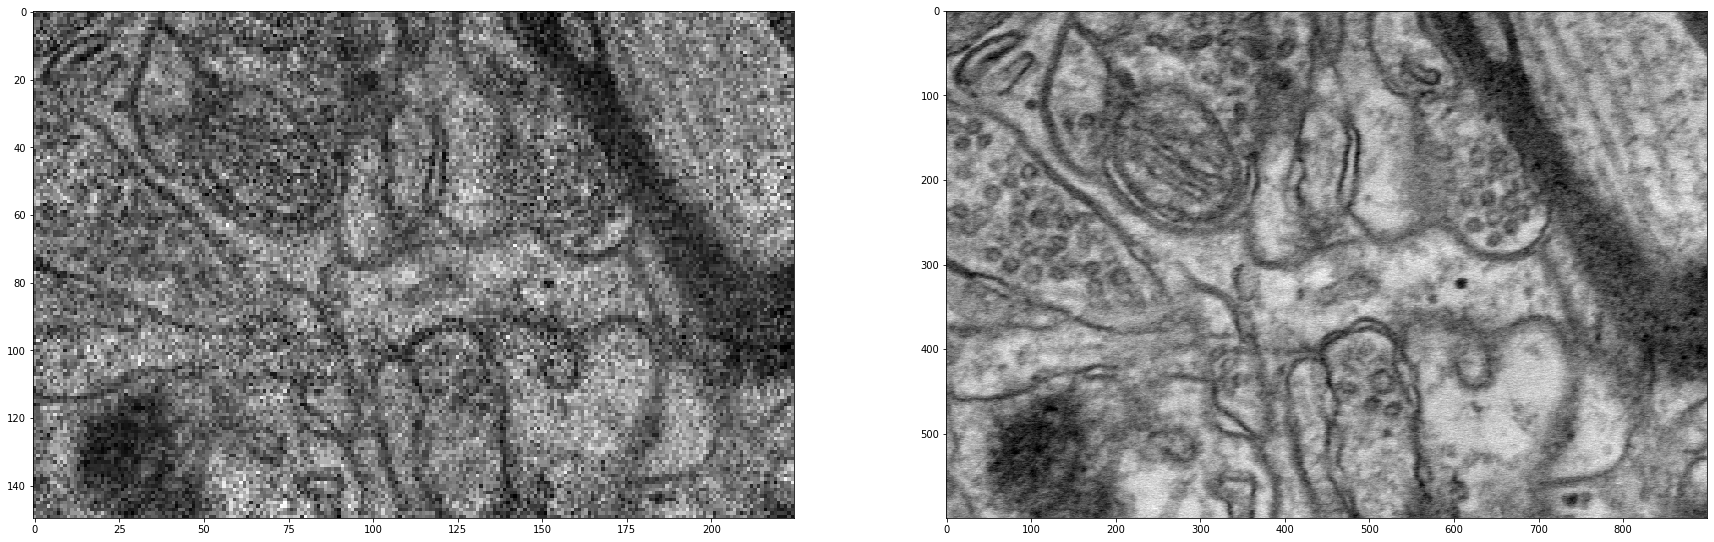

In [10]:
sn = 8 # image number
lr_im = data.utils.load_img(lr_files[sn]) # load image to tensor
hr_im = data.utils.load_img(hr_files[sn]) # load image to tensor
f, axarr = plt.subplots(1,2) # create visualizations
axarr[0].imshow(np.squeeze(lr_im), cmap=plt.cm.gray) # visualize image tensor
axarr[1].imshow(np.squeeze(hr_im), cmap=plt.cm.gray) # visualize image tensor
plt.show() # show visualizationiff.

## Image Visualization

In [12]:
def show_image(x):
    plt.imshow(np.squeeze(x), cmap=plt.cm.gray)
    plt.show()

In [14]:
def show_imagepair(x, y):
    f, axarr = plt.subplots(1,2) # create visualizations
    axarr[0].imshow(np.squeeze(x), cmap=plt.cm.gray) # visualize image tensor
    axarr[1].imshow(np.squeeze(y), cmap=plt.cm.gray) # visualize image tensor
    plt.show() # show visualization

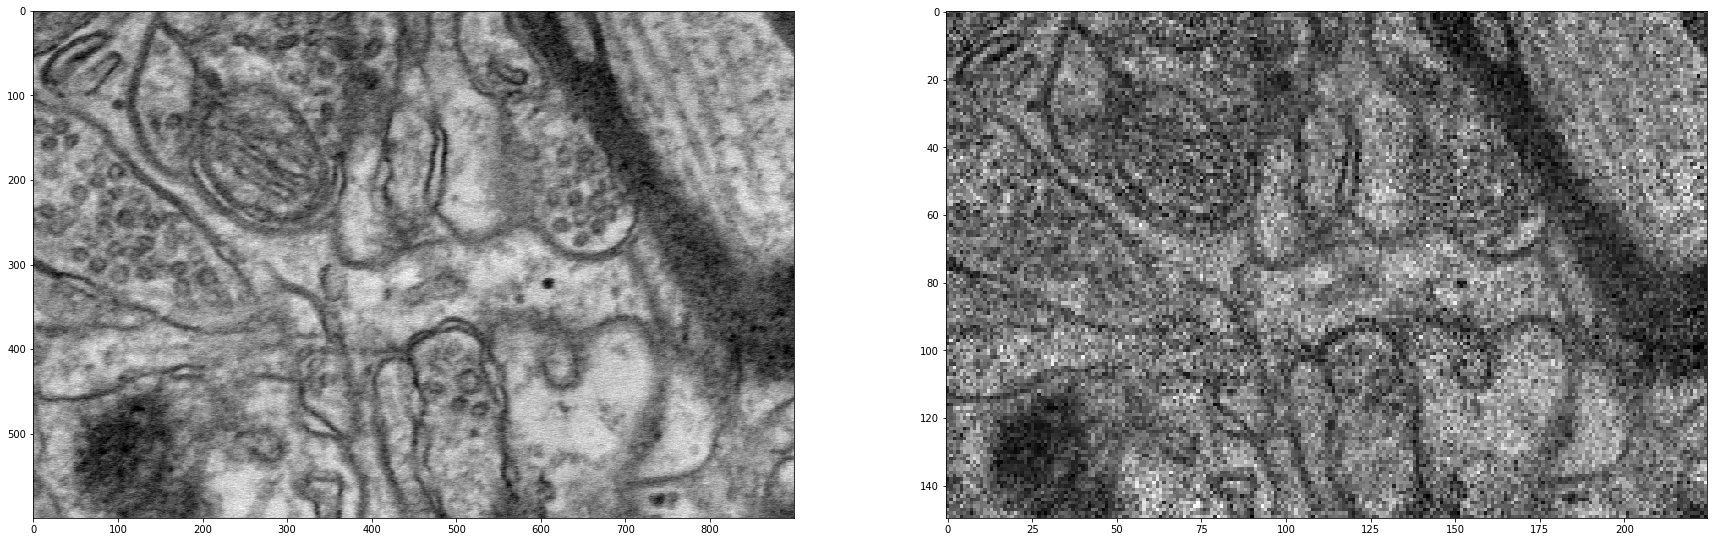

In [15]:
show_imagepair(hr_im, lr_im)

In [16]:
hr_im.shape

(1, 600, 900)

## Generate Images with Patches Removed

In [74]:
img = hr_im

In [46]:
# TESTS
min_height = 5
max_height = 15
min_width = 5
max_width = 15
np.arange(min_height, max_height)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [58]:
num_imgs = 10
num_patches = np.random.choice(np.arange(5, 10))
patch_heights_range = np.arange(min_height, max_height)
patch_widths_range = np.arange(min_width, max_width)
height_steps = np.random.choice(patch_heights_range, size=num_patches)
width_steps = np.random.choice(patch_widths_range, size=num_patches)
np.random.choice(patch_heights_range, size=num_patches)

array([ 7,  8, 10, 11, 10, 13,  7,  6])

In [59]:
print(height_steps)
print(width_steps)

[ 8  5 11  5  5 10  8 13]
[ 8  6  8 14  9 11  8  6]


In [60]:
img_dims = img.shape
print(img_dims)
height_start_coords = np.random.choice(img_dims[1]-max_height, size=num_patches)
width_start_coords = np.random.choice(img_dims[2]-max_width, size=num_patches)
print(height_start_coords)
print(width_start_coords)

(1, 512, 512)
[455 211 466 312 350 209  37 237]
[386  73 198 445 167 482 317 133]


In [50]:
img_files = hr_files[:10]

In [ ]:
faiv.uni

In [80]:
tfms = [custom_cutout()]

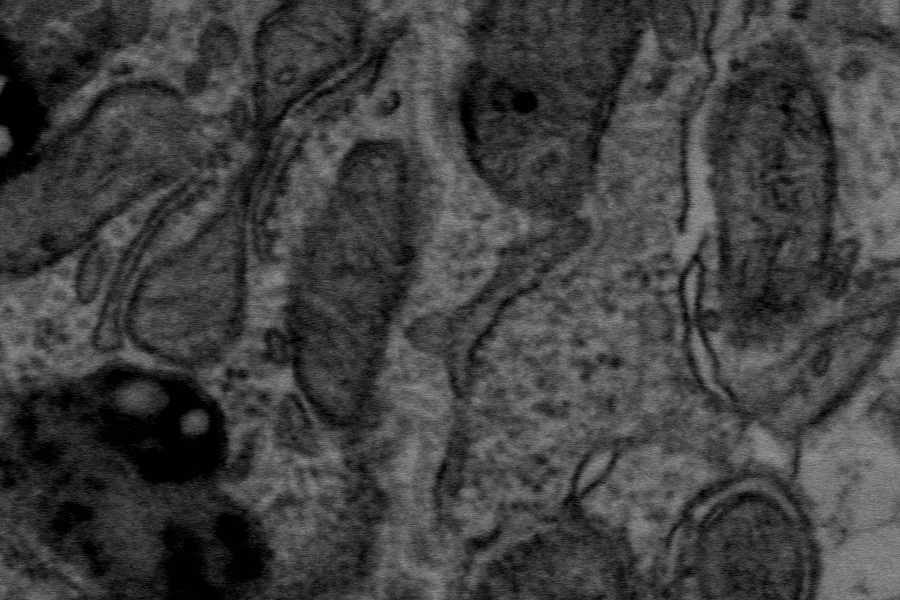

In [88]:
faiv.open_image(hr_files[0])

In [79]:
def _custom_cutout(x, min_n_holes:faiv.uniform_int=5, max_n_holes:faiv.uniform_int=10,
                   min_length:faiv.uniform_int=5, max_length:faiv.uniform_int=15):
    "Cut out `n_holes` number of square holes of size `length` in image at random locations."
    h,w = x.shape[1:]
    n_holes = np.random.randint(min_n_holes, max_n_holes)
    h_length = np.random.randint(min_length, max_length)
    w_length = np.random.randint(min_length, max_length)
    for n in range(n_holes):
        h_y = np.random.randint(0, h)
        h_x = np.random.randint(0, w)
        y1 = int(np.clip(h_y - h_length / 2, 0, h))
        y2 = int(np.clip(h_y + h_length / 2, 0, h))
        x1 = int(np.clip(h_x - w_length / 2, 0, w))
        x2 = int(np.clip(h_x + w_length / 2, 0, w))
        x[:, y1:y2, x1:x2] = 0
    return x

custom_cutout = faiv.TfmPixel(_custom_cutout, order=20)

In [89]:
def visualize_transforms(img_fname, rows, cols, width, height, **kwargs):
    [faiv.open_image(img_fname).apply_tfms(tfms, **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

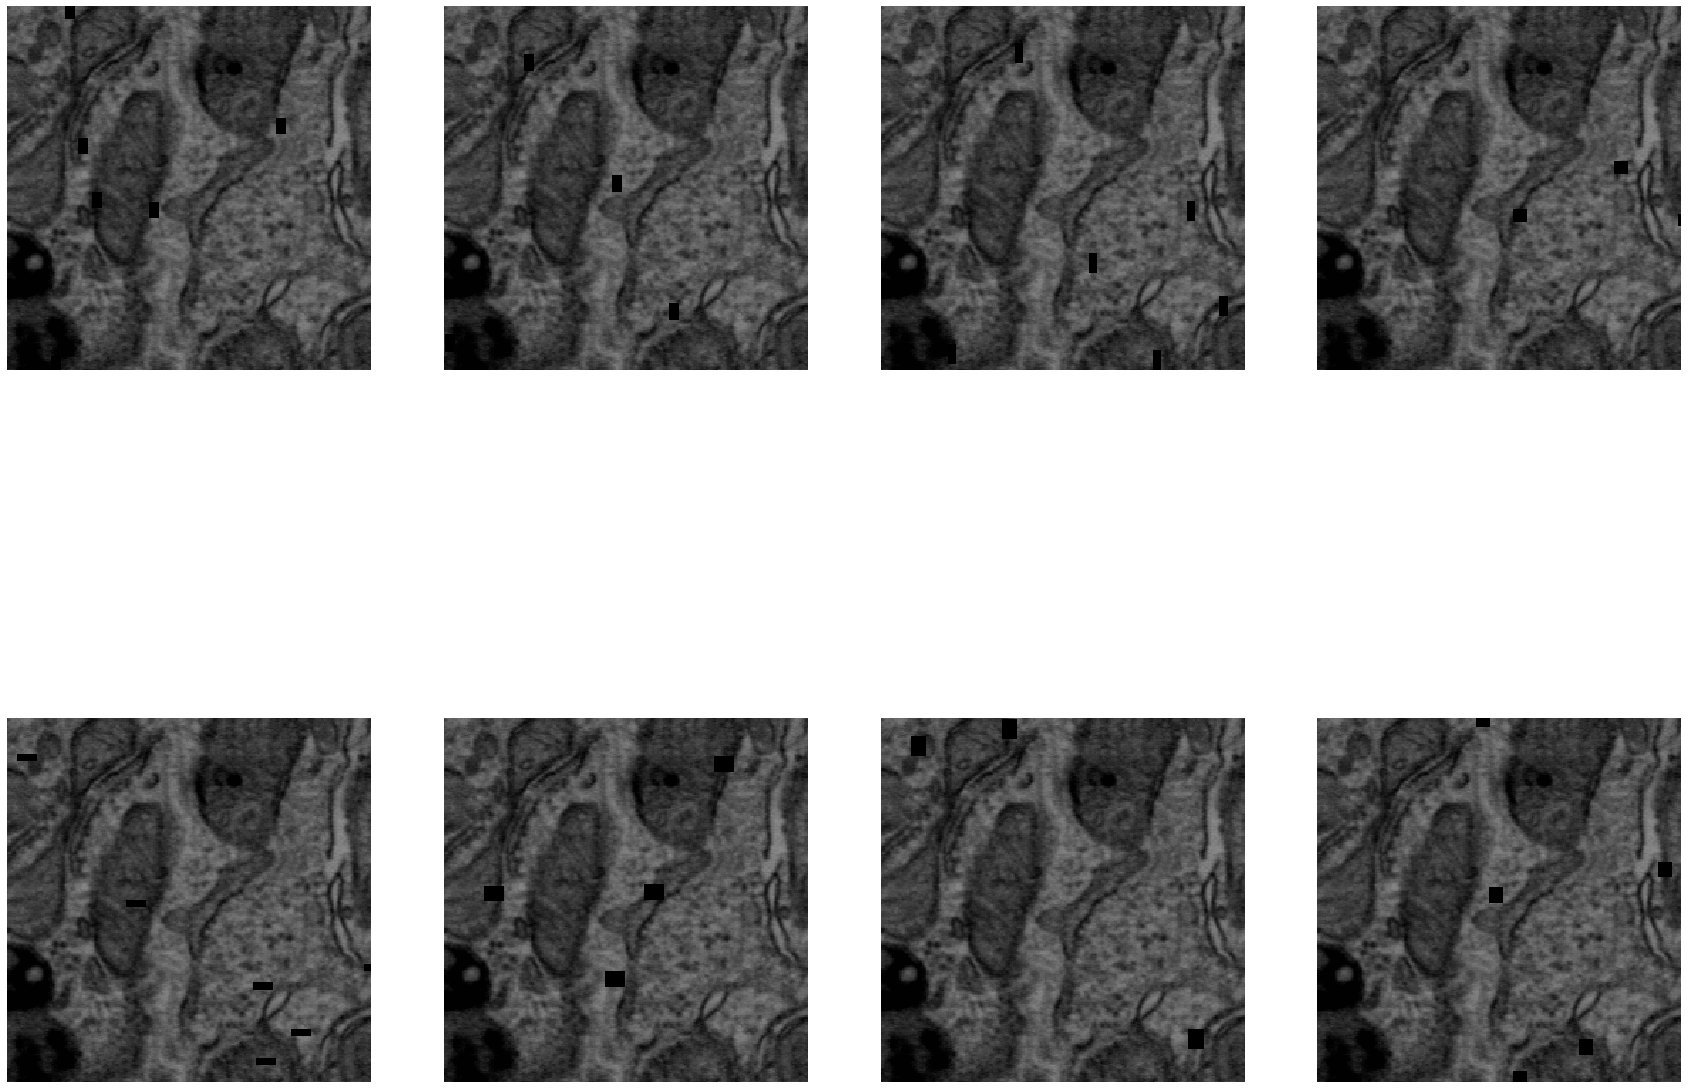

In [92]:
visualize_transforms(hr_files[0], 2, 4, 30, 24, size=256)

In [75]:
def make_patches(img, max_height, max_width,
                 patch_heights_range, patch_widths_range,
                 min_num_patches=5, max_num_patches=10):
    num_patches = np.random.choice(np.arange(min_num_patches, max_num_patches))
    img_dims = img.shape
    height_start_coords = np.random.choice(img_dims[1]-max_height, size=num_patches)
    width_start_coords = np.random.choice(img_dims[2]-max_width, size=num_patches)
    height_steps = np.random.choice(patch_heights_range, size=num_patches)
    width_steps = np.random.choice(patch_widths_range, size=num_patches)
    for i in range(num_patches):
        h_start, h_end = height_start_coords[i], height_start_coords[i] + height_steps[i]
        w_start, w_end = width_start_coords[i], width_start_coords[i] + width_steps[i]
        patch_size = (h_end-h_start, w_end-w_start)
        patch = np.zeros(patch_size)
        img[:, h_start:h_end, w_start:w_end] = patch
    return img

In [76]:
# TEST make_patches()
new_img = make_patches(img, max_height, max_width, patch_heights_range, patch_widths_range)

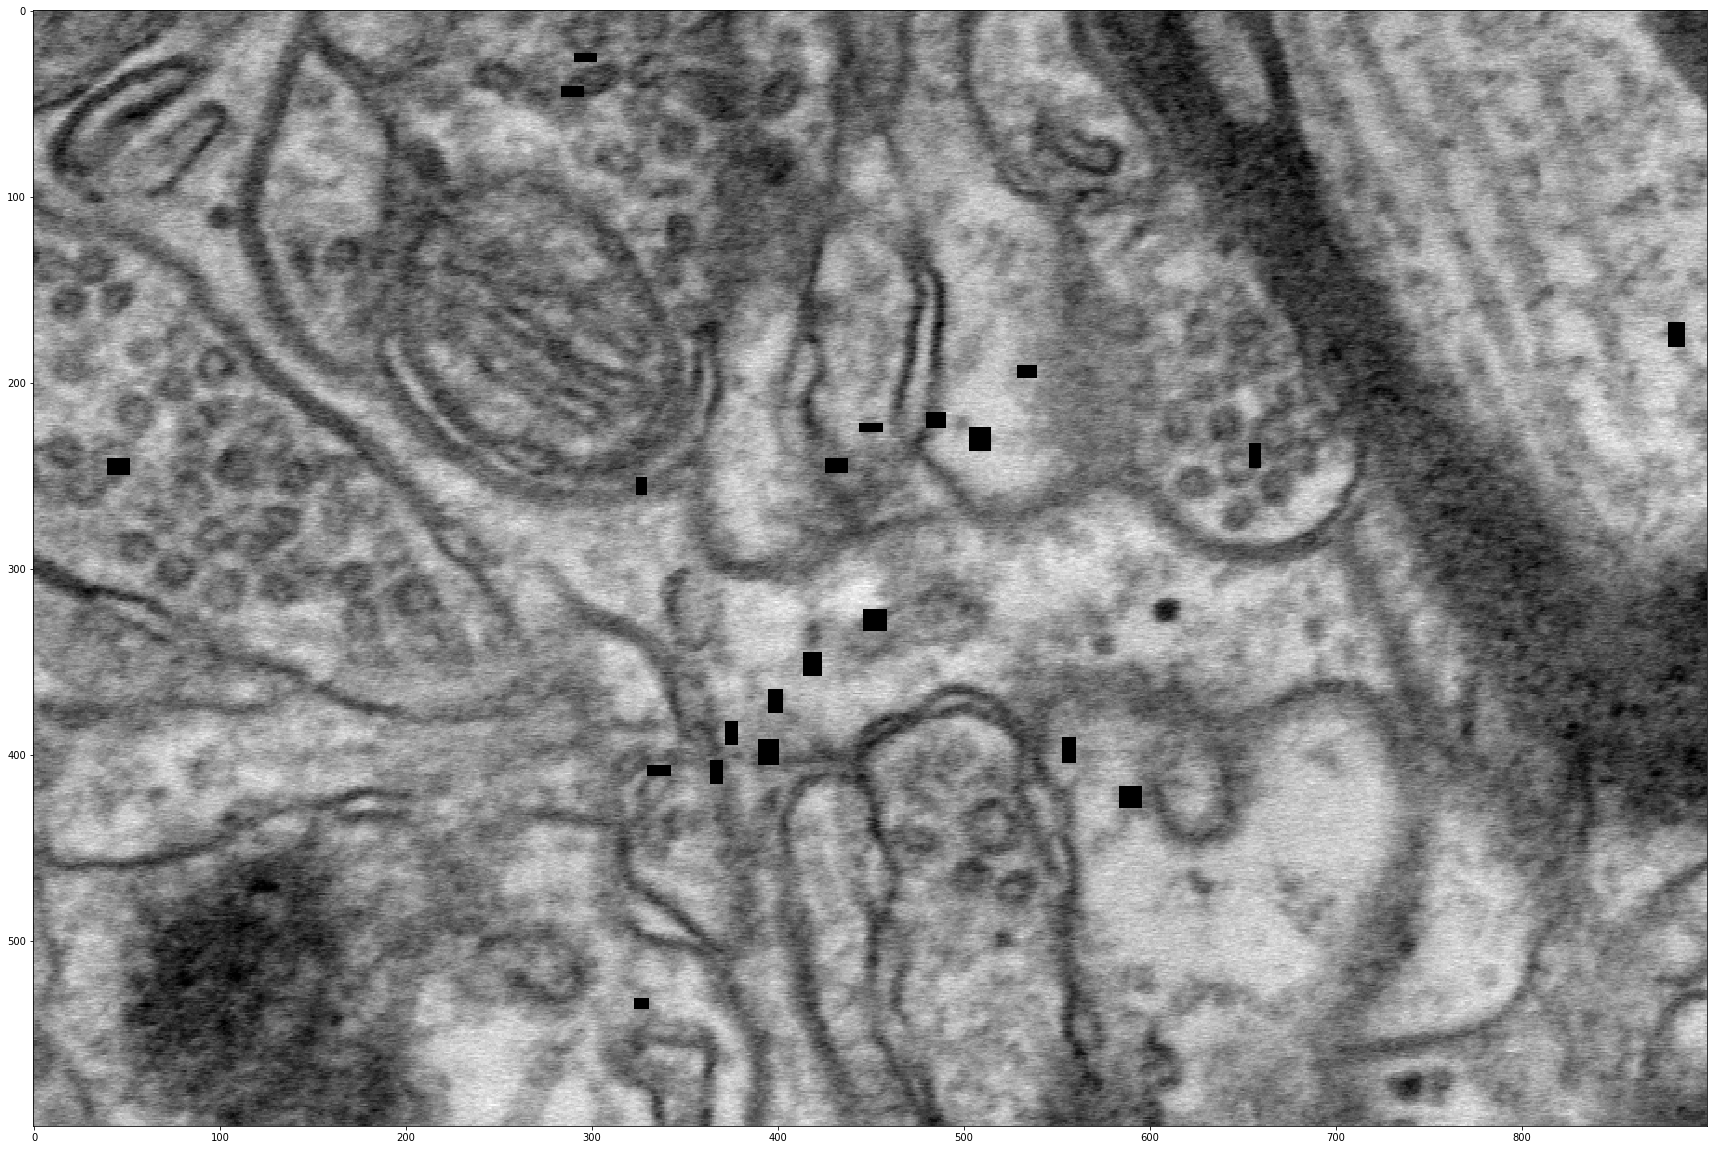

In [77]:
show_image(new_img)

In [57]:
for i, img_fname in enumerate(img_files):
    img = crop_center(load_img(img_fname), 256, 256)
    img = make_patches(img, max_height, max_width, patch_heights_range, patch_widths_range)
    save_img(img, output_dir/img_fname)
    if i % 1000 == 0:
        print(f'Completed {i} Patch Crappifications')
        print(f'Last file saved in {output_dir/img_fn.stem.replace('hr', patch)}')
    print("Patch Crappification Process Completed. Enjoy!"

(5, 11)
(10, 7)
(9, 7)
(8, 12)
(5, 11)
(13, 9)
(13, 9)
(11, 7)
(12, 11)
(9, 11)


In [63]:
img_fname.stem.replace('hr', 'patch')

'EM_train_patch_00010'

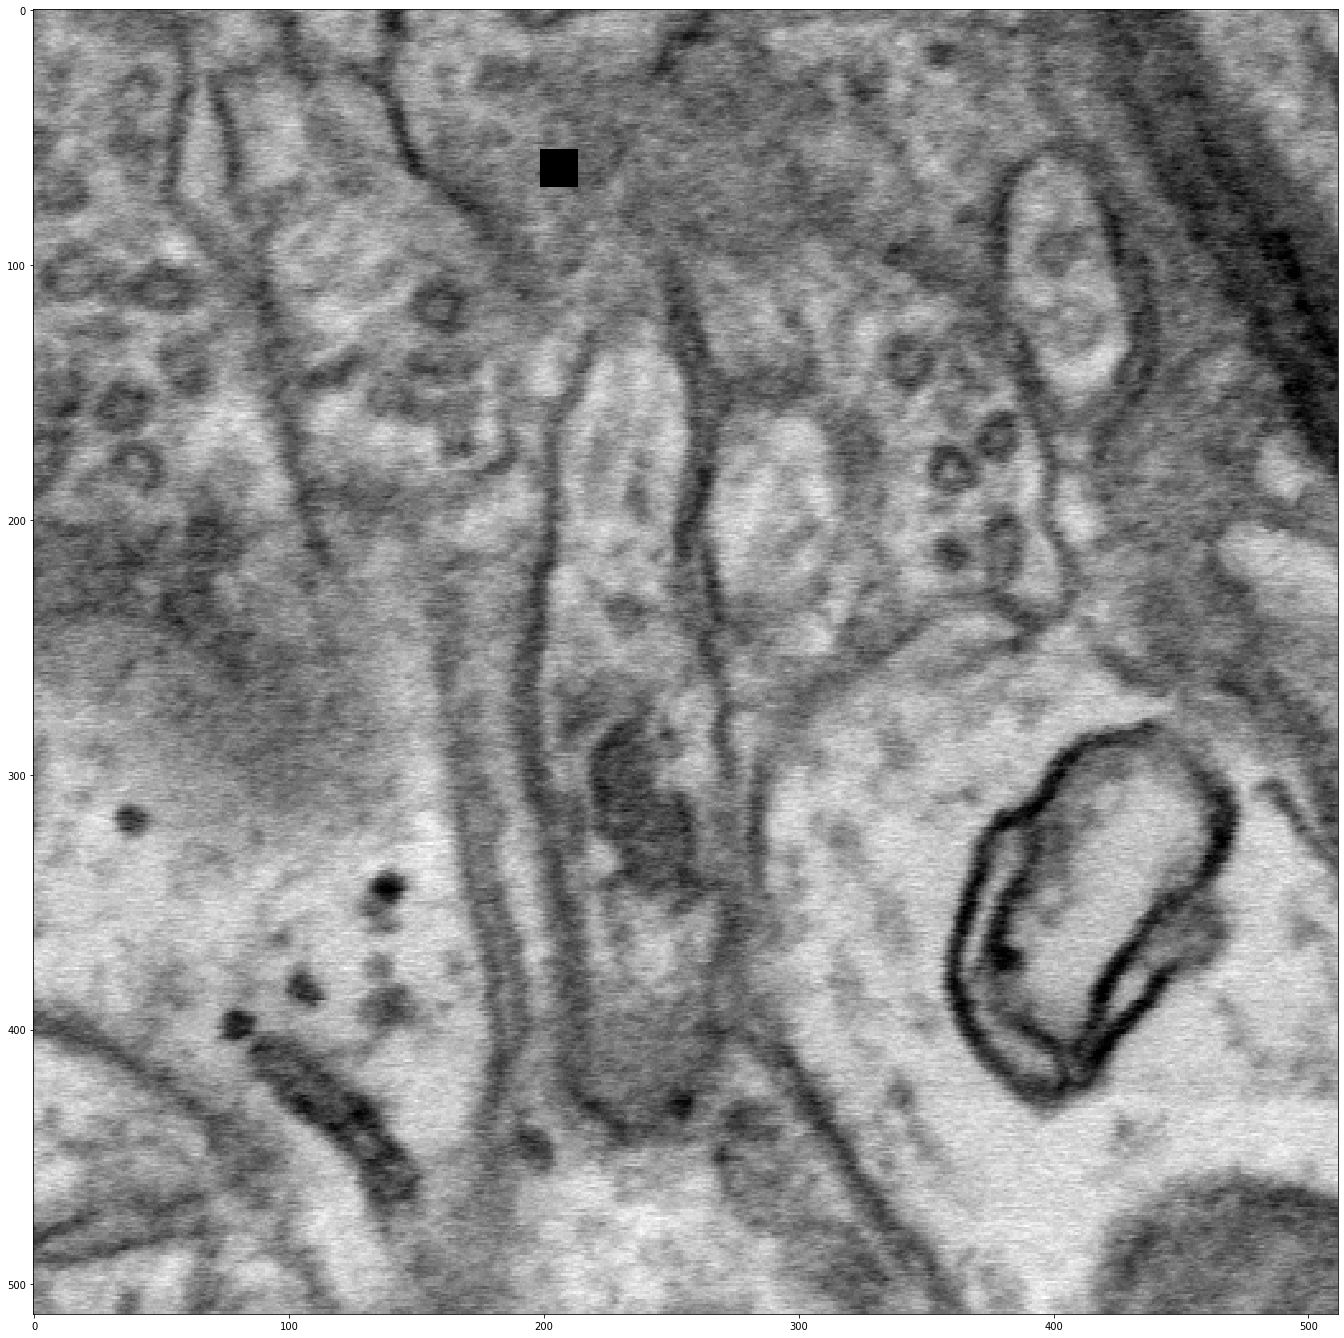

In [56]:
show_image(img)

In [ ]:
# start coords (0,0); end coords (h-max_h, w-max_w)
patch_heights_range = np.arange(min_height, max_height)
patch_widths_range = np.arange(min_width, max_width)
height_steps = np.random.choice(patch_heights_range, size=num_imgs)
width_steps = np.random.choice(patch_widths_range, size=num_imgs)
height_start_coords = np.random.choice(img_dims[1]-max_height, size=num_imgs)
width_start_coords = np.random.choice(img_dims[2]-max_width, size=num_imgs)
for i, img_fname in enumerate(img_files):
    h_start, h_end = height_start_coords[i], height_start_coords[i] + height_steps[i]
    w_start, w_end = width_start_coords[i], width_start_coords[i] + width_steps[i]
    patch_size = (h_end-h_start, w_end-w_start)
    patch = np.zeros(patch_size)
    img = load_img(img_fname)
    img[:, h_start:h_end, w_start:w_end] = patch
    save_img(svd_im, output_dir/(img_fname.stem+'.tif'))  # save patched image
    if i % 1000 == 0:
        print(f'Completed {i} Patch Crappifications')
        print(f'Last file saved in {output_dir/img_fn.stem}')
    print("Patch Crappification Process Completed. Enjoy!"

## Compute SVD-compressed Image

In [8]:
def svd_process(img_files, output_dir, k_start=30, k_end=40):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    k_range = np.arange(k_start, k_end+1)
    ks = np.random.choice(k_range, size=len(img_files), replace=True)
    for i, img_fn in enumerate(img_files):
        img = data.utils.load_img(img_fn)  # load image
        svd_im = data.svd.compute_svd(img, k=ks[i])  # compute SVD image
        svd_im = 255.*(svd_im - np.min(svd_im))/np.ptp(svd_im)
        data.utils.save_img(svd_im, output_dir/(img_fn.stem+'.tif'))  # save SVD image
        if i % 1000 == 0:
            print(f'Completed {i} SVD Crappifications')
            print(f'Last file saved in {output_dir/img_fn.stem}')
    print("SVD Crappification Process Completed. Enjoy!")

In [9]:
svd_dir_name = f'training/trainsets/svd'
svd_dir_path = path/f'{svd_dir_name}_30_40'
svd_process(hr_files, svd_dir_path)

../../data/svd.py:23: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(np.flip(eigvals))


Completed 0 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_00001
Completed 2000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_02001
Completed 3000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_03001
Completed 4000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_04001
Completed 5000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_05001
Completed 6000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_06001
Completed 7000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_tra

Completed 62000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_62001
Completed 63000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_63001
Completed 64000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_64001
Completed 65000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_65001
Completed 66000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_66001
Completed 67000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30_40/EM_train_hr_67001
Completed 68000 SVD Crappifications
Last file saved in /data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd_30

In [44]:
img_fn = hr_files[0]
svd_dir_path/img_fn

PosixPath('/data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/hr/EM_train_hr_00001.tif')

In [45]:
svd_dir_path/(img_fn.stem+'.tif')

PosixPath('/data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/svd/EM_train_hr_00001.tif')

# Questions for Andrew
- how to parallelize the SVD process function?
- if we can parallelize, how am I supposed to save them to file?

In [9]:
hr_im.shape

(1, 600, 900)

In [ ]:
# Go with HR SVD k=35-40

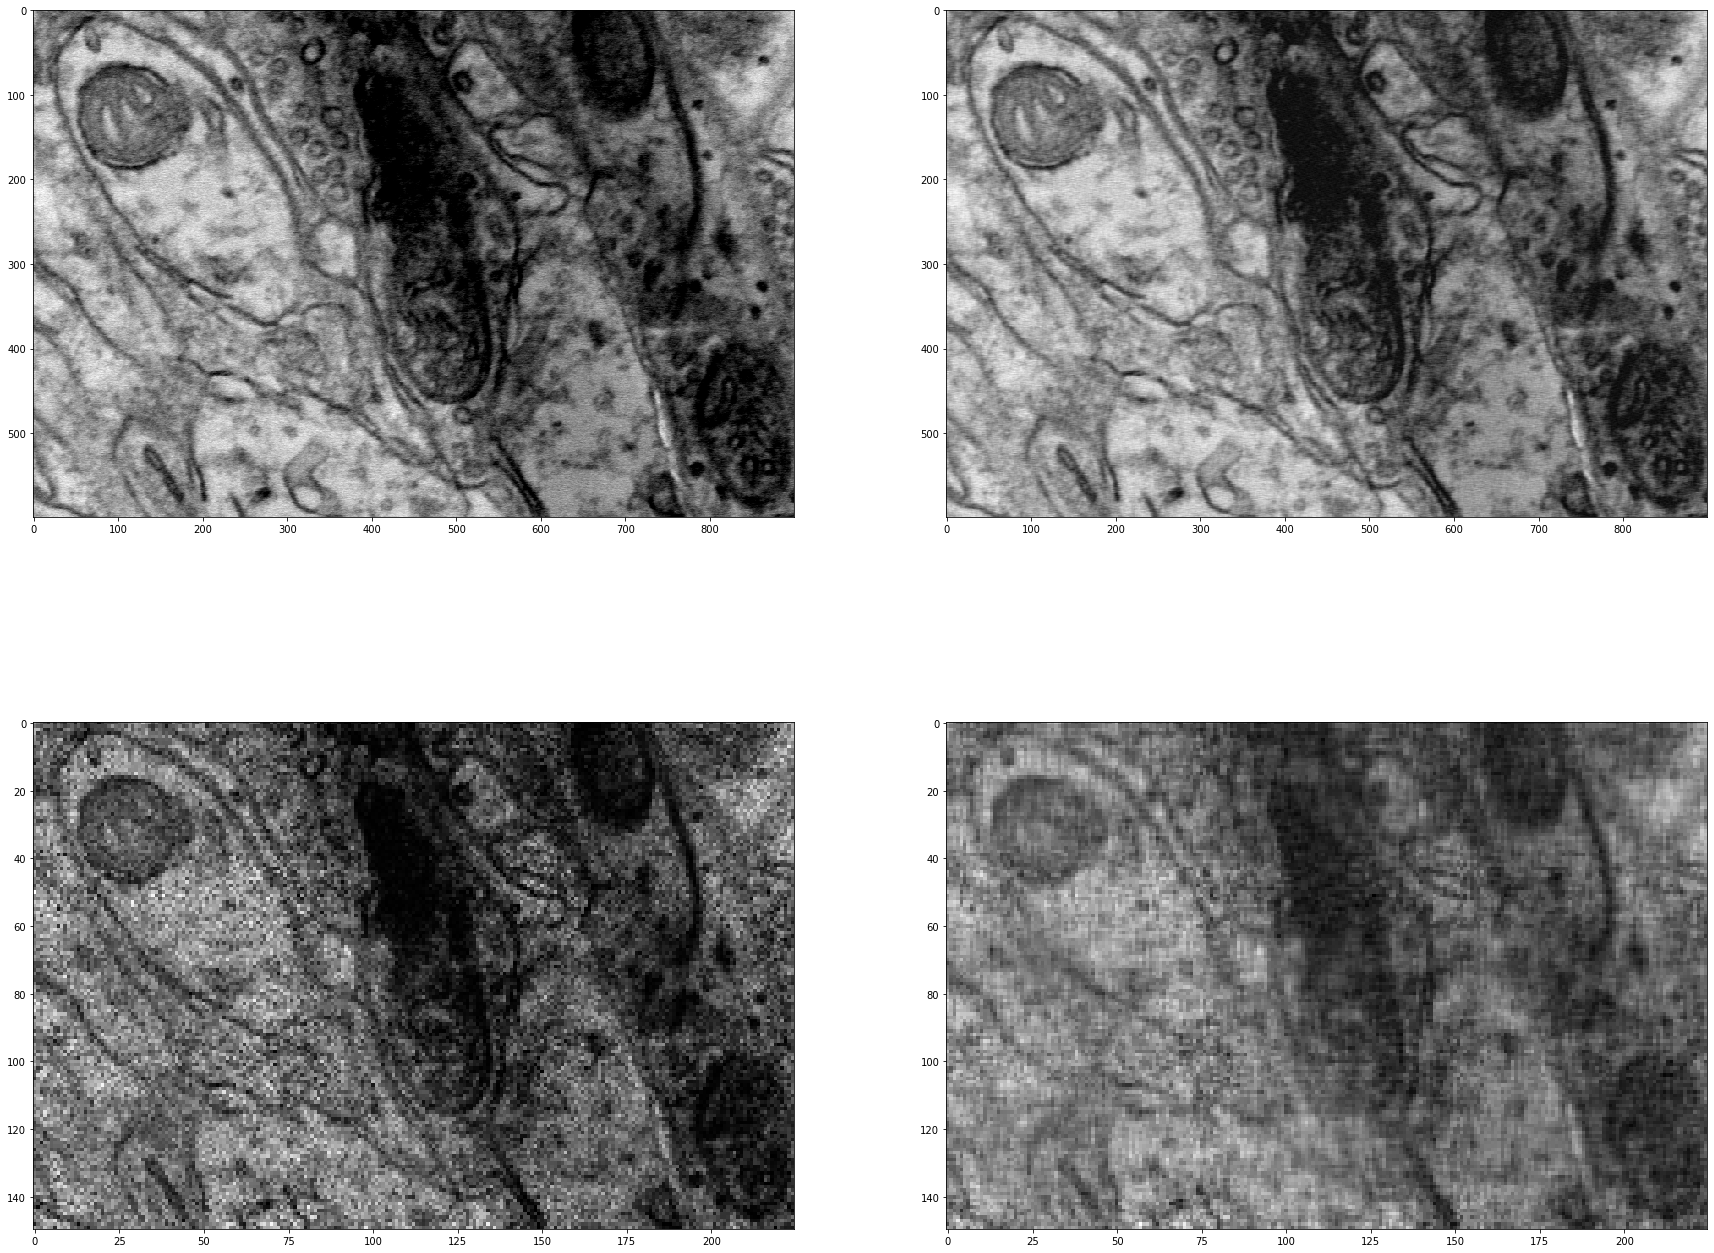

In [32]:
sn = 20 # image number
k1 = 30
k2 = 150
hr_im = data.utils.load_img(hr_files[sn])  # load HR image to tensor
lr_im = data.utils.load_img(lr_files[sn])  # load LR image to tensor
svd_lr_im = data.svd.compute_svd(lr_im, k=k1)  # compute svd image
svd_hr_im = data.svd.compute_svd(hr_im, k=k2)  # compute svd image
f, axarr = plt.subplots(2,2) # create visualizations
axarr[0][0].imshow(np.squeeze(hr_im), cmap=plt.cm.gray) # visualize image tensor
axarr[0][1].imshow(np.squeeze(svd_hr_im), cmap=plt.cm.gray)  # visualize image tensor
axarr[1][0].imshow(np.squeeze(lr_im), cmap=plt.cm.gray)  # visualize image tensor
axarr[1][1].imshow(np.squeeze(svd_lr_im), cmap=plt.cm.gray)  # visualize image tensor

plt.show() # show visualization

In [31]:
hr_files[sn]

PosixPath('/data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/hr/EM_train_hr_00021.tif')

In [33]:
svd_im = 255.*(svd_hr_im - np.min(svd_hr_im))/np.ptp(svd_hr_im)
data.utils.save_img(svd_im, 'sample_EM_svd_150.tif')  # save SVD image

In [26]:
svd_hr_im = data.svd.compute_svd(hr_im, k=k2)  # compute svd image

../../data/svd.py:23: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(np.flip(eigvals))


In [28]:
t = PIL.Image.fromarray(np.squeeze(svd_hr_im))

In [32]:
t2 = 255.*(t - np.min(t))/np.ptp(t)

In [33]:
np.max(t2), np.min(t2)

(254.99998, 0.0)

In [34]:
t3 = data.utils.img_to_uint8(t2)

In [17]:
data.utils.save_img(svd_im, "svd_test.tif")

In [25]:
np.max(svd_hr_im), np.min(svd_hr_im)

(255.0, -17.960753705342228)

In [24]:
svd_hr_im *= 255 / np.max(svd_hr_im)

In [21]:
t = data.utils.img_to_uint8(svd_hr_im)

In [26]:
imageio.mimwrite("test.tiff", t, )

In [25]:
hr_files[sn]

PosixPath('/home/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/hr/EM_train_hr_00009.tif')

In [30]:
im = PIL.Image.fromarray(np.squeeze(t))

In [31]:
im.save('test2.tif')

In [55]:
img = libtiff.TiffFile(hr_files[sn])

NotImplementedError: 'rgb'

In [50]:
t = img.get_tiff_array()[0]

In [51]:
t.shape

(600, 900)

# Load and Write using PIL (RGB)

In [59]:
im = PIL.Image.open(hr_files[sn])

In [60]:
im.load()

In [63]:
im

'RGB'

In [64]:
im.save('test3.tif')